In [61]:
import numpy as np
import scipy as sp
from scipy.signal import savgol_filter
from matplotlib.ticker import ScalarFormatter

import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_theme()

In [564]:
drv425evm_raw = pd.read_csv("./nov-9-drv425-prlm-stm32-distance-test.txt", names=["prlm_drv425"])



In [565]:
len(np.array(drv425evm_raw["prlm_drv425"]))
len(np.repeat(np.arange(3, 32), 20))

580

In [566]:
df = pd.DataFrame({"distance":np.repeat(np.arange(3, 32), 20),"reading": np.array(drv425evm_raw["prlm_drv425"])})

In [567]:
df

,distance,reading
0,3,3777.0000
1,3,3777.0000
2,3,3777.1875
3,3,3777.0000
4,3,3776.8125
...,...,...
575,31,2837.4375
576,31,2837.6250
577,31,2837.4375
578,31,2837.2500


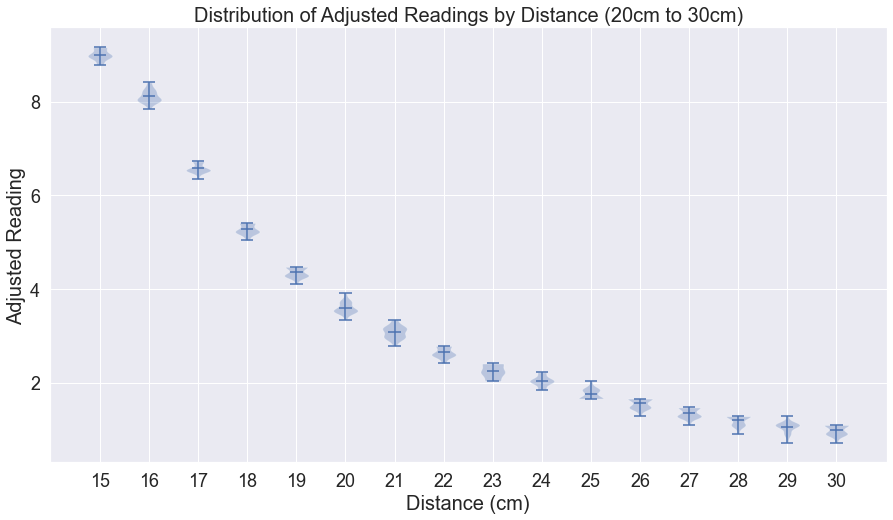

In [568]:
# Identify and mark the base readings which are the last 20 rows for distance '31'
base_readings = df[df['distance'] == 31]['reading']

# Smooth the base readings by calculating the mean
base_reading_smooth = base_readings.mean()

# Subtract the smooth base reading from all readings
df['adjusted_reading'] = df['reading'] - base_reading_smooth

# df['adjusted_reading'] *= 0.0204918

# Filter the DataFrame for distances 20cm to 30cm (excluding base reading at 31)
filtered_df = df[(df['distance'] >= 15) & (df['distance'] < 31)]

# Prepare the data for violin plotting
distances = np.unique(filtered_df['distance'])
data_to_plot = [filtered_df[filtered_df['distance'] == dist]['adjusted_reading'].values for dist in distances]

# Create the violin plot using Matplotlib
fig, ax = plt.subplots(figsize=(15, 8))
ax.violinplot(data_to_plot, positions=distances, showmeans=True, showmedians=False)

ax.set_title('Distribution of Adjusted Readings by Distance (20cm to 30cm)', fontsize=20)
ax.set_xlabel('Distance (cm)', fontsize=20)
ax.set_ylabel('Adjusted Reading', fontsize=20)
ax.set_xticks(distances)
ax.set_xticklabels([f"{int(dist)}" for dist in distances])
plt.tick_params(axis='both', which='major', labelsize=18)  # Enlarge major tick labels
plt.tick_params(axis='both', which='minor', labelsize=18)  # Enlarge minor tick labels if used
plt.grid(True)
plt.show()

In [64]:

def moving_average(data, window_size):
    # Create a window/kernel for the moving average
    window = np.ones(window_size) / window_size
    # Apply convolution between your data and the window
    smoothed_data = np.convolve(data, window, mode='valid')
    return smoothed_data

In [57]:
np.linspace(0,15848, 15848)

array([0.00000000e+00, 1.00006310e+00, 2.00012621e+00, ...,
       1.58459999e+04, 1.58469999e+04, 1.58480000e+04])

In [65]:
def plot_3_channels(raw_df, filtering=False, filter_func=savgol_filter, window_length=51, polyorder=2, no_of_anchors_to_plot=3):
    from matplotlib.ticker import ScalarFormatter

    # Create a figure and a set of subplots
    fig, axs = plt.subplots(no_of_anchors_to_plot, 1, figsize=(10, 15), dpi=200)

    # Define a plain number formatter
    formatter = ScalarFormatter(useOffset=False)

    for i, column in enumerate(raw_df.columns):

        if (i + 1 > no_of_anchors_to_plot):
            continue

        # check if filtering is required for the drawing
        # if YES, run the filtering algo before execute the drawing commands
        data = raw_df[column]
        if (filtering):
            data = filter_func(data, window_length, polyorder)

        axs[i].plot(raw_df.index, data)
        if (filtering): axs[i].set_title(column + " smoothed with savgol filter: window len of 51")
        else : axs[i].set_title(column + " no filtering")
        axs[i].set_xlabel("Samples(100 samples/sec)")
        axs[i].set_ylabel('Field Strength(mV)')

        # Apply plain number format to both x and y axis
        axs[i].xaxis.set_major_formatter(formatter)
        axs[i].yaxis.set_major_formatter(formatter)

    # Adjust the layout
    plt.tight_layout()

    # Display the plot
    plt.show()



def plot_3_channels_with_gradients(raw_df, filtering=True, window_length=51, polyorder=2):
    # Create a figure and a set of subplots
    fig, axs = plt.subplots(6, 1, figsize=(10, 12), dpi=200)  # 6 subplots for 3 channels and their gradients

    # Define a plain number formatter
    formatter = ScalarFormatter(useOffset=False)

    for i, column in enumerate(raw_df.columns[:3]):  # Assume first 3 columns are channels
        data = raw_df[column]
        if filtering:
            data = savgol_filter(data, window_length, polyorder)
        
        # Calculate the gradient
        gradient = np.gradient(data)

        # Plot the original data
        axs[2*i].plot(raw_df.index, data, label=f'Original Data')
        axs[2*i].set_title(f'{column} Data')
        axs[2*i].set_ylabel('Field Strength (mV)')
        axs[2*i].xaxis.set_major_formatter(formatter)
        axs[2*i].yaxis.set_major_formatter(formatter)

        # Plot the gradient
        axs[2*i + 1].plot(raw_df.index, gradient, label='Gradient', color='orange')
        axs[2*i + 1].set_title(f'{column} Gradient')
        axs[2*i + 1].set_ylabel('Gradient (mV/sample)')
        axs[2*i + 1].xaxis.set_major_formatter(formatter)
        axs[2*i + 1].yaxis.set_major_formatter(formatter)

    # Set the xlabel for the last subplot only
    axs[-1].set_xlabel('Samples (100 samples/sec)')

    # Add legends
    for ax in axs:
        ax.legend()

    plt.tight_layout()
    plt.show()

# Assuming raw_df is your DataFrame with the data
# plot_3_channels_with_gradients(raw_df)



In [59]:
raw_df_first = pd.read_csv("./data/feb-1-multi-sensor-deploy-test.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_second = pd.read_csv("./data/feb-1-multi-sensor-deploy-test-second.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_third = pd.read_csv("./data/feb-1-multi-sensor-deploy-test-no-action.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_20cm_from_server_laptop_battery = pd.read_csv("./data/feb-5-multi-sensor-deploy-test-20cm-from-server-rack-laptop-battery.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_20cm_from_server_power_cable = pd.read_csv("./data/feb-5-multi-sensor-deploy-test-20cm-from-server-rack-power-cable.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_120cm_from_server_power_cable = pd.read_csv("./data/feb-5-multi-sensor-deploy-test-120cm-from-server-rack-power-cable.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_120cm_from_server_laptop_battery = pd.read_csv("./data/feb-5-multi-sensor-deploy-test-120cm-from-server-rack-laptop-battery.txt", names=["anchor_0", "anchor_1", "anchor_2"])

raw_df_PRMM_laptop_battery_single = pd.read_csv("./data/feb-5-PRMM-single-place-remove-laptop-battery.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_PRMM_laptop_battery_multiple = pd.read_csv("./data/feb-5-PRMM-multi-place-remove-laptop-battery.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_PRMM_laptop_battery_multiple_bottle_height_2 = pd.read_csv("./data/feb-5-PRMM-multi-place-remove-bottle-laptop-battery-sensor-height-2-magnet-height-2cm.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_PRMM_laptop_battery_multiple_bottle_height_3 = pd.read_csv("./data/feb-5-PRMM-multi-place-remove-bottle-laptop-battery-sensor-height-3-magnet-height-2cm.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_PRM_laptop_battery_multiple_bottle_height_3 = pd.read_csv("./data/feb-5-PRM-multi-place-remove-bottle-laptop-battery-sensor-height-3-magnet-height-2cm.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_PRM_laptop_battery_multiple_bottle_sensor_height_3_magnet_height_0cm = pd.read_csv("./data/feb-5-PRM-multi-place-remove-bottle-laptop-battery-sensor-height-3-magnet-height-0cm.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_PRM_laptop_battery_multiple_no_bottle_sensor_height_3_magnet_height_0cm = pd.read_csv("./data/feb-5-PRM-multi-place-remove-no-bottle-laptop-battery-sensor-height-3-magnet-height-0cm.txt", names=["anchor_0", "anchor_1", "anchor_2"])

raw_df_PRM_cable_static = pd.read_csv("./data/feb-7-PRM-static-cable-sensor-height-3-magnet-height-0cm.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_PRM_battery_static = pd.read_csv("./data/feb-7-PRM-static-battery-sensor-height-3-magnet-height-0cm.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_PRM_static_PRMM_move_battery = pd.read_csv("./data/feb-7-PRM-static-PRMM-place-remove-battery-sensor-height-3-magnet-height-0cm.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_PRMM_static_PRM_move_battery = pd.read_csv("./data/feb-7-PRMM-static-PRM-place-remove-battery-sensor-height-3-magnet-height-0cm.txt", names=["anchor_0", "anchor_1", "anchor_2"])



raw_df_PRM_PRMM_place_remove_3_times = pd.read_csv("./data/feb-12-PRM-and-PRMM-place-remove-3-times.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_PRM_PRM_place_remove_remove_place = pd.read_csv("./data/feb-12-PRM-and-PRM-place-remove-remove-place.txt", names=["anchor_0", "anchor_1", "anchor_2"])

FileNotFoundError: [Errno 2] No such file or directory: './data/feb-1-multi-sensor-deploy-test.txt'

### plotting of AlcoMax-PRM magnet trials

* multiple placement and removal actions(3) 
* laptop battery supplied
* sensor height at position 3
* magnet height at 0 centimeter
* magnet attached to bottle


In [ ]:
plot_3_channels_with_gradients(raw_df=raw_df_PRMM_static_PRM_move_battery)


In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate, find_peaks

def correlate_channel_template(data_stream, template, data_name, template_name, positive_template_flag=True):
    channel_data = data_stream
    channel_gradient = np.gradient(channel_data)

    # Replace negative values in the template with zeros, if flagged
    gradient_val_template = np.maximum(template, 0) if positive_template_flag else template


    # Check and handle NaNs and Infs before correlation
    if np.isnan(gradient_val_template).any() or np.isnan(channel_gradient).any():
        print("Warning: NaN values found in the data. They will be replaced with zeros.")
        gradient_val_template = np.nan_to_num(gradient_val_template)
        channel_gradient = np.nan_to_num(channel_gradient)

    if np.isinf(gradient_val_template).any() or np.isinf(channel_gradient).any():
        print("Warning: Infinite values found in the data. They will be replaced with large finite numbers.")
        gradient_val_template = np.nan_to_num(gradient_val_template, nan=0.0, posinf=np.finfo(np.float64).max, neginf=np.finfo(np.float64).min)
        channel_gradient = np.nan_to_num(channel_gradient, nan=0.0, posinf=np.finfo(np.float64).max, neginf=np.finfo(np.float64).min)

    # Perform cross-correlation
    print(channel_gradient)
    print(gradient_val_template)
    correlation = correlate(channel_gradient, gradient_val_template, mode='full')
    # print(channel_gradient)
    # print(gradient_val_template)
    # print(correlation)
    normalized_correlation = correlation / np.max(correlation)  # Normalize the correlation

    # Find both positive and negative peaks in the correlation result
    peaks_positive, _ = find_peaks(normalized_correlation, prominence=0.8)
    print(peaks_positive)
    peaks_negative, _ = find_peaks(-normalized_correlation, prominence=0.8)
    print(peaks_negative)
    # Merge and sort peaks
    peaks_corr = np.sort(np.concatenate((peaks_positive, peaks_negative)))

    # Set up subplots
    fig, axs = plt.subplots(4, 1, figsize=(10, 8), dpi=300)

    # Plot channel data and mark peaks based on correlation
    axs[0].plot(channel_data, label=f'{data_name} Data')
    for peak in peaks_corr:
        # Map correlation index to data index
        data_index = peak - len(gradient_val_template) // 2
        if 0 <= data_index < len(channel_data):
            axs[0].plot(data_index, channel_data[data_index], "x", color='red')
    axs[0].set_title(f'{data_name} Channel Data')
    axs[0].set_xlabel('Samples')
    axs[0].set_ylabel('Field Strength (mV)')

    # Plot channel gradient and mark peaks based on correlation
    axs[1].plot(channel_gradient, color='orange', label=f'{data_name} Gradient')
    for peak in peaks_corr:
        data_index = peak - len(gradient_val_template) // 2
        if 0 <= data_index < len(channel_gradient):
            axs[1].plot(data_index, channel_gradient[data_index], "x", color='red')
    axs[1].set_title(f'{data_name} Channel Gradient')
    axs[1].set_xlabel('Samples')
    axs[1].set_ylabel('Gradient (mV/sample)')

    # Plot cross-correlation result and mark peaks
    print(normalized_correlation)
    axs[2].plot(normalized_correlation, label='Normalized Correlation')
    axs[2].plot(peaks_positive, normalized_correlation[peaks_positive], "x", color='green', label='Positive Peaks')
    axs[2].plot(peaks_negative, normalized_correlation[peaks_negative], "x", color='blue', label='Negative Peaks')
    axs[2].set_title(f'Normalized Cross-Correlation between {data_name} and {template_name}')
    axs[2].set_xlabel('Lag')
    axs[2].set_ylabel('Correlation Coefficient')
    axs[2].legend(loc="lower right", prop={'size': 6})

    # Plot the template
    axs[3].plot(gradient_val_template, label='Template')
    axs[3].set_title(f'Template: {template_name}')
    axs[3].set_xlabel('Samples')
    axs[3].set_ylabel("Gradient (mV/sample)")
    axs[3].legend()

    plt.tight_layout()
    plt.show()

# Example usage
# data_stream = np.array([...])  # Your data here
# template = np.array([...])  # Your template here
# correlate_channel_template(data_stream, template, 'Data Stream', 'Template')



In [ ]:
gradient_vals = np.gradient(raw_df_PRM_laptop_battery_multiple_bottle_sensor_height_3_magnet_height_0cm["anchor_2"])
gradient_val_template = np.gradient(raw_df_PRM_laptop_battery_multiple_bottle_sensor_height_3_magnet_height_0cm["anchor_0"].iloc[410:530])
gradient_val_template.shape

In [ ]:
gradient_template_smoothed = savgol_filter(gradient_val_template, window_length=41, polyorder=2)
gradient_template_smoothed = gradient_template_smoothed[40: 80]
plt.plot(gradient_val_template)

In [ ]:
plot_3_channels_with_gradients(raw_df_PRM_laptop_battery_multiple_bottle_sensor_height_3_magnet_height_0cm)

In [ ]:
correlate_channel_template(raw_df_PRM_laptop_battery_multiple_bottle_sensor_height_3_magnet_height_0cm["anchor_0"], gradient_template_smoothed, "PRM-place/remove-CH0", "PRM-place-CH0-template-smoothed", positive_template_flag=True)

In [ ]:
plot_3_channels_with_gradients(raw_df_PRM_static_PRMM_move_battery)

In [67]:
def stability_check(derivative_array, thresholds, num_chunks=5):
    
    summed_deri = np.array([])
    # aggregate the gradient sub-arrays for comparison
    for i in range(5):
        summed_deri = np.append(summed_deri, np.sum(np.abs(derivative_array[i*20: i*20 + 20])))
    # print(summed_deri)

    # compared all summed values to thresholds
    if (summed_deri[0] <= thresholds[0] and 
        summed_deri[1] <= thresholds[1] and 
        summed_deri[2] <= thresholds[2] and 
        summed_deri[3] <= thresholds[3] and 
        summed_deri[4] <= thresholds[4]):
        
        # successfully transitioned into stablized mode
        return True
    else:
        return False


In [68]:
def place_remove_detect(data_input, window_size=100, threshold_array=np.array([1.05, .95, .85, .75, .65,])):
    # Constants for the number of samples to check and the number of chunks
    num_samples = len(data_input)
    num_chunks = window_size // len(threshold_array)  # Assuming threshold_array length divides window_size
    dict = {}   

    # Initialize arrays to hold the timestamps of various events
    stability_change_stamps = []
    placement_stamps = []
    removal_stamps = []
    some_threshold = 0.7
    stability_mode = False

    # Compute the gradient and replace NaNs with zero
    gradient_values = np.nan_to_num(np.gradient(data_input))
    # Initialize a variable to track the last stable value for comparison
    last_stable_value = None

    # Loop through gradient values in windows of `window_size`
    for indx in range(0, num_samples, num_chunks):
        print(indx)
        # Define the current window of gradient values
        current_window = gradient_values[indx:indx+window_size]

        # Check if the current window is stable
        if stability_check(current_window, threshold_array, num_chunks):

            # Record the time stamp for when the system becomes stable
            if not stability_mode:
                stability_mode = True
                stability_change_stamps.append(indx)
                dict[indx] = "UNSTABLE --> STABLE"
                # print("system goes from UNSTABLE into STABLE")

            # Check for placement or removal only if the last stable value is available
            if last_stable_value is not None:
                current_stable_value = np.mean(data_input[indx:indx+window_size])
                
                # Check if there is a significant increase (placement)
                if current_stable_value > last_stable_value + some_threshold:
                    placement_stamps.append(indx)

                # Check if there is a significant decrease (removal)
                elif current_stable_value < last_stable_value - some_threshold:
                    removal_stamps.append(indx)

            # Update the last stable value
            last_stable_value = np.mean(data_input[indx:indx+window_size])

        else:

            # Record when the system leaves stability, if it was previously stable
            if stability_mode:
                stability_mode = False
                stability_change_stamps.append(indx)
                dict[indx] = "STABLE --> UNSTABLE"
                # print("system goes from STABLE into UNSTABLE")

    
    formatter = ScalarFormatter(useOffset=False)

    # Set up subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 5), dpi=300)

     # Plot original data with placement and removal stamps
    axs[0].plot(data_input, label='Original Data')
    
    # Initialize the legend handled dictionaries
    legend_handles = {'Placement': False, 'Removal': False}

    for stamp in placement_stamps:
        axs[0].axvline(x=stamp, color='g', linestyle='--')
        if not legend_handles['Placement']:
            axs[0].axvline(x=stamp, color='g', linestyle='--', label='Placement')
            legend_handles['Placement'] = True

    for stamp in removal_stamps:
        axs[0].axvline(x=stamp, color='r', linestyle='--')
        if not legend_handles['Removal']:
            axs[0].axvline(x=stamp, color='r', linestyle='--', label='Removal')
            legend_handles['Removal'] = True

    axs[0].set_title('Original Data with Event Markers')
    axs[0].set_xlabel('Samples')
    axs[0].set_ylabel('Field Strength (mV)')
    axs[0].xaxis.set_major_formatter(formatter)
    axs[0].yaxis.set_major_formatter(formatter)
    axs[0].legend(loc="upper right", prop={'size': 6})

    # Plot channel gradient and mark peaks based on correlation
    axs[1].plot(gradient_values, label="Gradient Tracking", color="orange")

    legend_handles = {'Placement': False, 'Removal': False}

    for stamp in placement_stamps:
        axs[1].axvline(x=stamp, color='g', linestyle='--')
        if not legend_handles['Placement']:
            axs[1].axvline(x=stamp, color='g', linestyle='--', label='Placement')
            legend_handles['Placement'] = True

    for stamp in removal_stamps:
        axs[1].axvline(x=stamp, color='r', linestyle='--')
        if not legend_handles['Removal']:
            axs[1].axvline(x=stamp, color='r', linestyle='--', label='Removal')
            legend_handles['Removal'] = True

    axs[1].set_title(f'Channel Gradient')
    axs[1].set_xlabel('Samples')
    axs[1].set_ylabel('Gradient (mV/sample)')
    axs[1].xaxis.set_major_formatter(formatter)
    axs[1].yaxis.set_major_formatter(formatter)
    axs[1].legend(loc="upper right", prop={'size': 6})

    plt.tight_layout()
    plt.show()

    print(len(dict))

    return stability_change_stamps, placement_stamps, removal_stamps, dict


    
    

In [69]:
def compute_mse(data):
    # Calculate the ad-hoc sampling frequency
    data_len = data.shape[0]
    adhoc_fs = data_len / 53.0

    # Compute base chunk mean values
    base_chunk = data[0:int(4 * adhoc_fs), :]
    base_mean = np.mean(base_chunk, axis=0)

    # Initialize MSE results list with base mean values
    results = {'base': base_mean}

    # Define the positions chunks
    positions = [(5, 9), (15, 19), (25, 29), (35, 39)]

    # Loop through positions to compute mean and MSE
    for i, (start, end) in enumerate(positions, start=1):
        chunk = data[int(start * adhoc_fs):int(end * adhoc_fs), :]
        chunk_mean = np.mean(chunk, axis=0)
        mse = np.mean((chunk_mean - base_mean) ** 2)
        results[f'mse_p{i}'] = mse

    return results

# Example usage
# Assuming `data` is a numpy array of shape [data_len, 5]
# data = np.random.rand(1000, 5)  # Example data, replace with actual data
# results = compute_mse(data)
# print(results)

In [ ]:
import os

# Define the directory containing the CSV files
directory = "./data/mar-21-comparison-among-soln-types"

# Loop through each file in the directory
for filename in os.listdir(directory):
    # Check if the file is a CSV
    if filename.endswith(".csv"):
        # Construct the full path to the file
        filepath = os.path.join(directory, filename)
        
        # Read the CSV file using pandas
        data = pd.read_csv(filepath).values  # Convert DataFrame to NumPy array for the function
        
        # Call the previously defined function to compute the MSE
        results = compute_mse(data)
        
        # Print the filename and the corresponding results
        print(f"Filename: {filename}, Results: {results}")

In [71]:
raw_df_prlm_x_12_5_y_30 = pd.read_csv("./../data/apr-4-prlm-localisation-data-each-position/apr-4-prlm-place-x=12-5-y=30__5-times.txt", names=["anchor_0", "anchor_1", "anchor_2", "anchor_3", "anchor_4"])

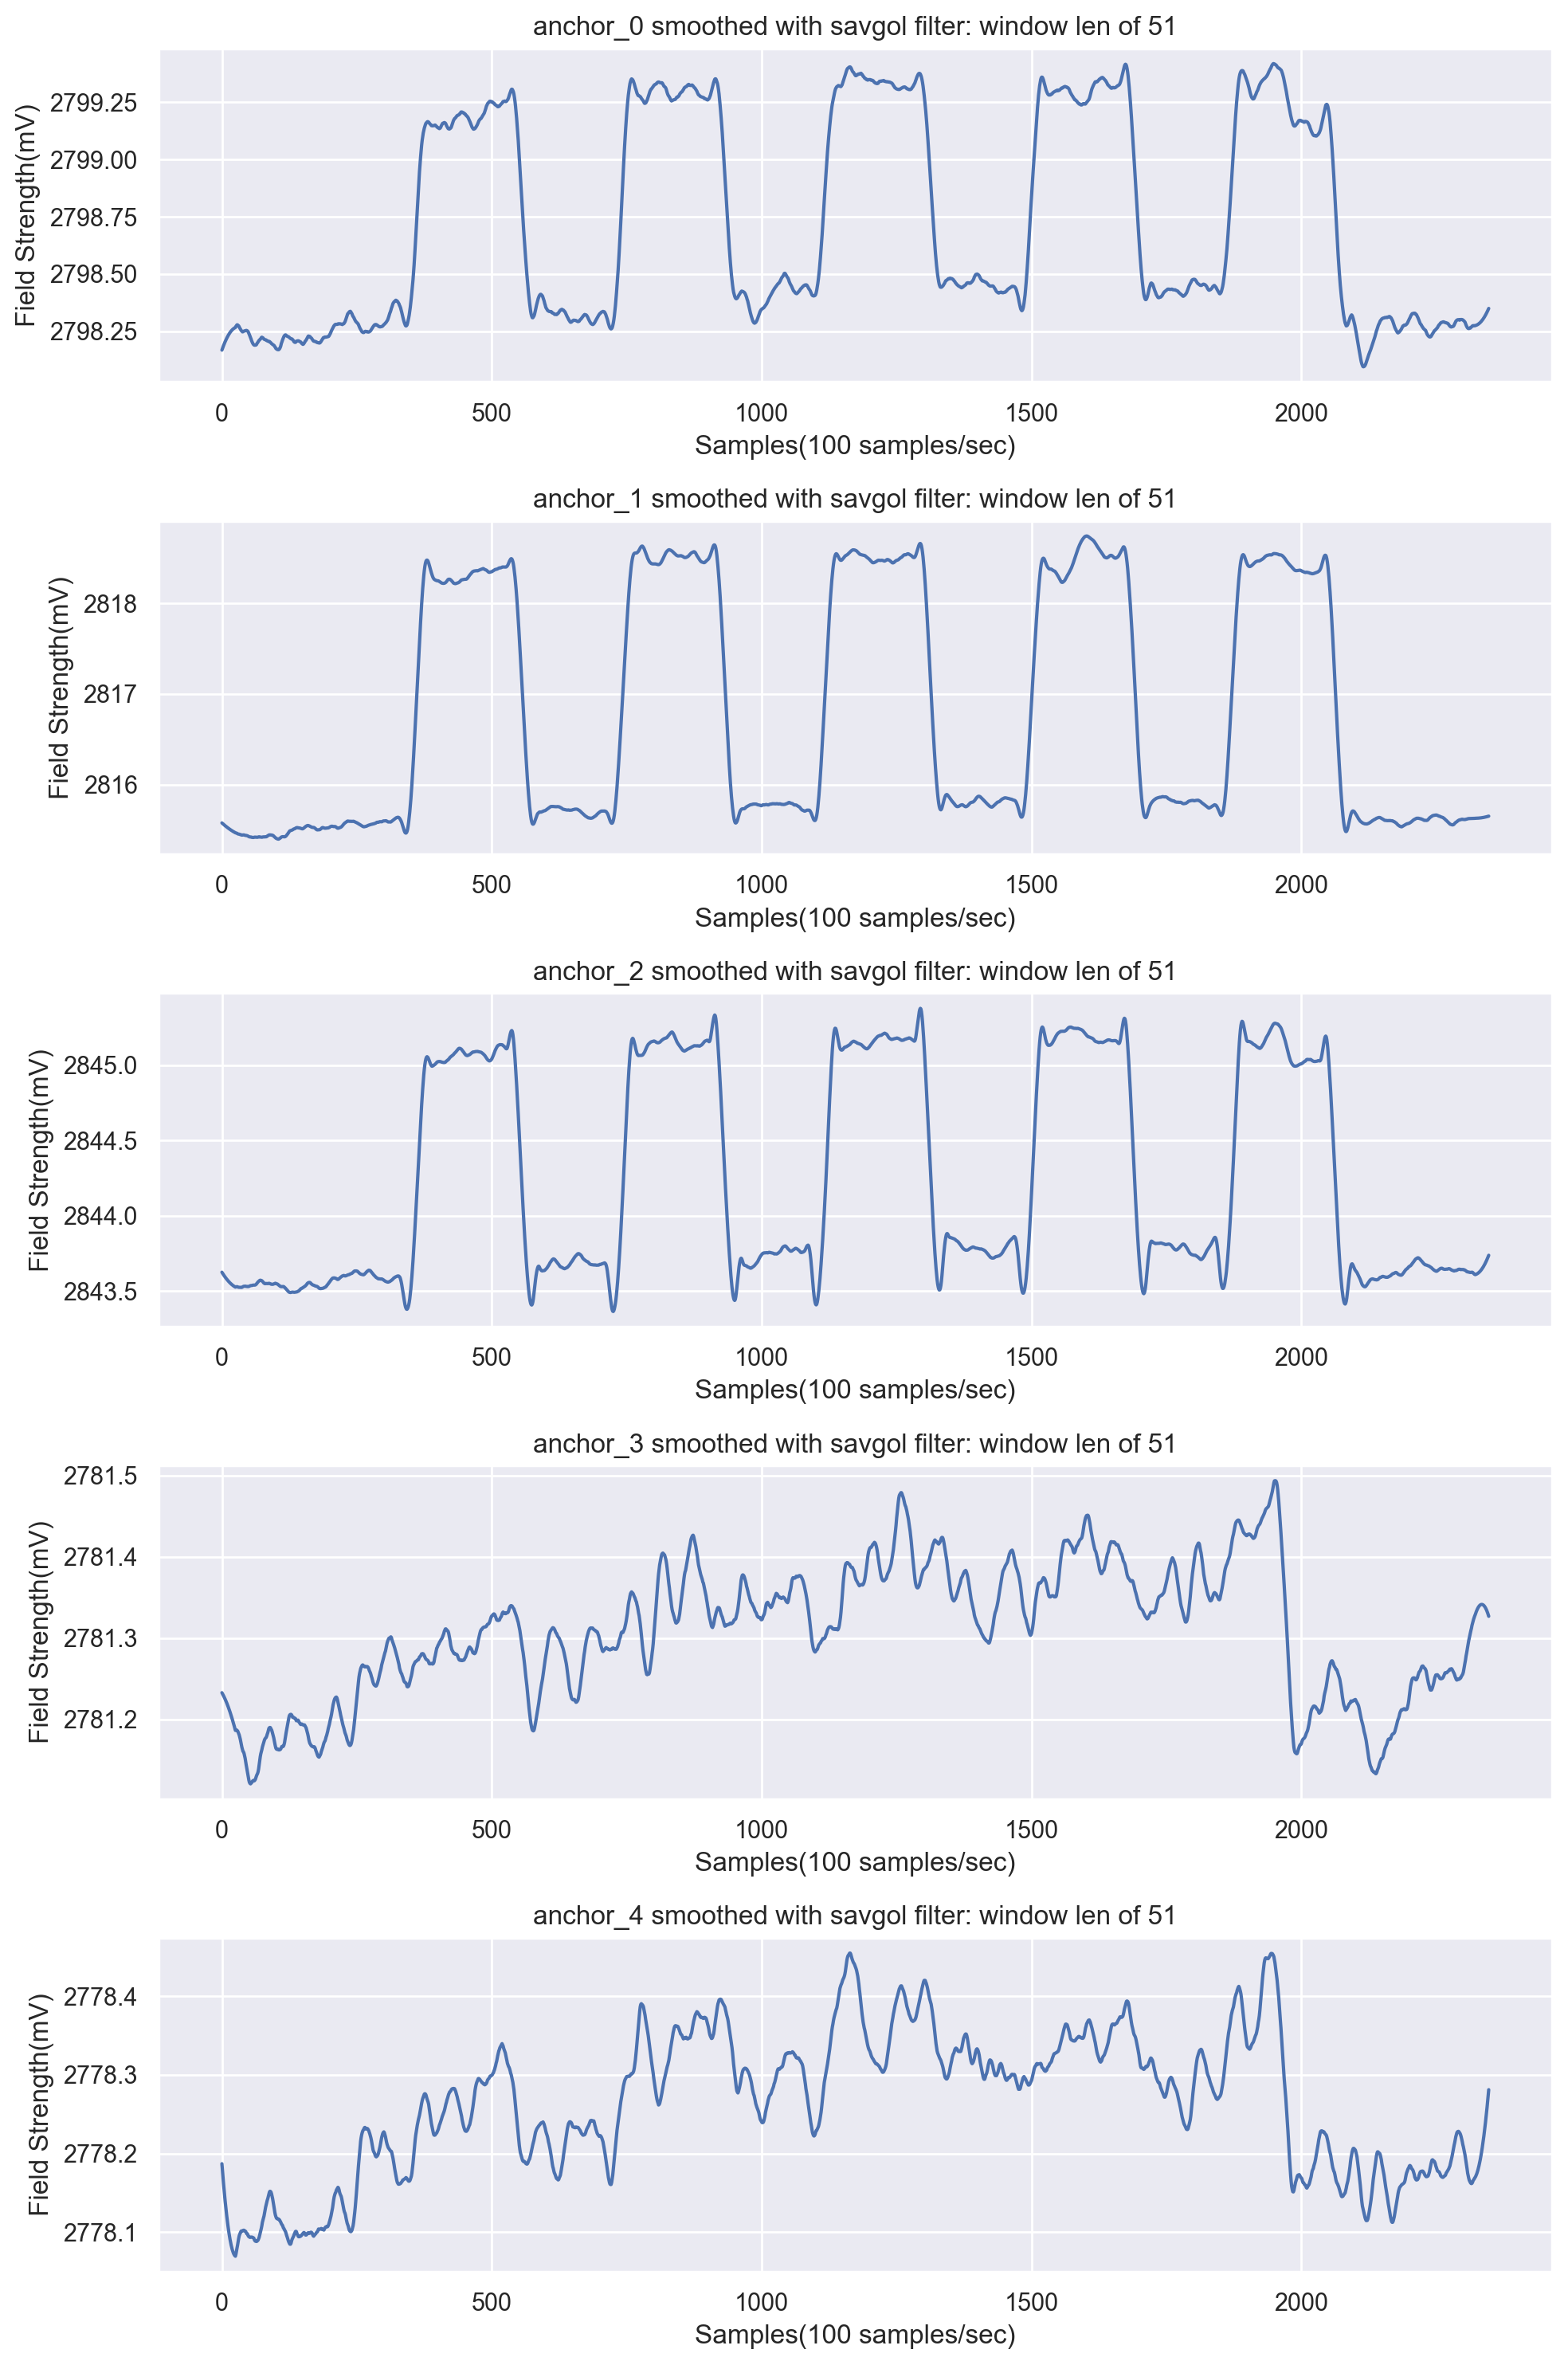

In [72]:
plot_3_channels(raw_df=raw_df_prlm_x_12_5_y_30, no_of_anchors_to_plot=5, filtering=True)

In [364]:
def stability_check(data, thresholds, method='intuition', num_chunks=5, chunk_size=10):
    # Check the selected method and apply the appropriate stability analysis
#     print(f"the method used in stability check func: {method}")

#     if method == 'gradient':
#         # Method 1: 1st Derivative Check
#         summed_deri = []
#         for i in range(num_chunks):
#             chunk = data[i * chunk_size:i * chunk_size + chunk_size]
#             abs_derivatives = np.abs(chunk)
#             sum_derivatives = np.mean(abs_derivatives)
#             summed_deri.append(sum_derivatives)
#         return np.all(np.array(summed_deri) <= thresholds)

    if method == 'std':
        # Method 2: Standard Deviation Check
        std_values = []
        for i in range(num_chunks):
            chunk = data[i * chunk_size:i * chunk_size + chunk_size]
            std_dev = np.std(chunk)
            std_values.append(std_dev)
#         print(std_values)
#         print(np.all(np.array(std_values) <= thresholds))
        return np.all(np.array(std_values) <= thresholds)

    elif method == 'intuition':
        # Method 3: Adjusted Percentile-based Check (Zero-mean average deviation check)
        deviations = []
        for i in range(num_chunks):
            chunk = data[i * chunk_size:(i + 1) * chunk_size]
            # Zero-mean the chunk
            chunk_zero_meaned = chunk - np.mean(chunk)
            # Calculate the average of the zero-meaned values (essentially the average deviation from the mean)
            avg_deviation = np.mean(np.abs(chunk_zero_meaned))
            deviations.append(avg_deviation)

        # Compare each chunk's average deviation to the corresponding threshold
        stability_result = np.all(np.array(deviations) <= thresholds)
#         print(stability_result)
        return stability_result

    else:
        raise ValueError("Unknown method specified. Use 'gradient', 'std', or 'percentile'.")


In [387]:
def calculate_thresholds(baseline_data, chunk_size, method='intuition', data_type="raw"):
    if data_type=="1st_derivative":
        baseline_data = np.nan_to_num(np.gradient(baseline_data))
    elif data_type=="2nd_derivative":
        baseine_data = np.nan_to_num(np.gradient(np.gradient(baseline_data)))
        
    num_chunks = len(baseline_data) // chunk_size
    measure_func = lambda chunk: np.percentile(chunk, 99.5) - np.mean(chunk)
    chunk_measures = [measure_func(baseline_data[i*chunk_size:(i+1)*chunk_size]) for i in range(num_chunks)]
    avg_threshold = np.mean(chunk_measures)
    return avg_threshold

def place_remove_detect(data_input, window_size=50, threshold_array_len=5, method='intuition', threshold_multipliers=None, data_type="raw"):
    num_samples = len(data_input)
    baseline_data = data_input[:300]
    chunk_size = window_size // threshold_array_len
    threshold = calculate_thresholds(baseline_data, chunk_size, "intuition", data_type)
    
    if threshold_multipliers is None:
        threshold_multipliers = np.ones(threshold_array_len)  # Default to all ones if none provided
    
    thresholds = threshold * np.array(threshold_multipliers)
    
    stability_change_stamps = []
    placement_stamps = []
    removal_stamps = []
    some_threshold = 0.7
    stability_mode = False
    stability_dict = {}
    
    first_deri = np.nan_to_num(np.gradient(data_input))
    second_deri = np.nan_to_num(np.gradient(first_deri))
    processed_data = data_input
    
    if data_type == "1st_derivative":
        processed_data = first_deri
    elif data_type == "2nd_derivative":
        processed_data = second_deri

    last_stable_value = None

    # Loop through the processed data in windows of `window_size`
    for indx in range(0, num_samples, window_size // threshold_array_len):
#         print(indx)
        if indx + window_size > num_samples:
            continue  # Avoid indexing beyond the end of the array
        current_window = processed_data[indx:indx + window_size]

        if stability_check(current_window, thresholds, method=method):
            if not stability_mode:
                stability_mode = True
                stability_change_stamps.append(indx)
                stability_dict[indx] = "UNSTABLE --> STABLE"

            if last_stable_value is not None:
                current_stable_value = np.mean(data_input[indx:indx + window_size])
                if current_stable_value > last_stable_value + some_threshold:
                    placement_stamps.append(indx)
                elif current_stable_value < last_stable_value - some_threshold:
                    removal_stamps.append(indx)

            last_stable_value = np.mean(data_input[indx:indx + window_size])
        else:
            if stability_mode:
                stability_mode = False
                stability_change_stamps.append(indx)
                stability_dict[indx] = "STABLE --> UNSTABLE"
                
                
                
    
    # Plotting logic
    fig, axs = plt.subplots(3, 1, figsize=(10, 7), dpi=300)
    axs[0].plot(data_input, label='Original Data')

    for stamp in placement_stamps:
        axs[0].axvline(x=stamp, color='g', linestyle='--', label=f'{method}*{threshold_multipliers} Place' if stamp == placement_stamps[0] else "")
    for stamp in removal_stamps:
        axs[0].axvline(x=stamp, color='r', linestyle='--', label=f'{method}*{threshold_multipliers} Remove' if stamp == removal_stamps[0] else "")

    

    axs[1].plot(first_deri, label='1st Derivative Tracking', color='orange')

    for stamp in placement_stamps:
        axs[1].axvline(x=stamp, color='g', linestyle='--', label=f'{method}*{threshold_multipliers} Place' if stamp == placement_stamps[0] else "")
    for stamp in removal_stamps:
        axs[1].axvline(x=stamp, color='r', linestyle='--', label=f'{method}*{threshold_multipliers} Remove' if stamp == removal_stamps[0] else "")

    axs[2].plot(second_deri, label='2nd Derivative Tracking', color='purple')

    for stamp in placement_stamps:
        axs[2].axvline(x=stamp, color='g', linestyle='--', label=f'{method}*{threshold_multipliers} Place' if stamp == placement_stamps[0] else "")
    for stamp in removal_stamps:
        axs[2].axvline(x=stamp, color='r', linestyle='--', label=f'{method}*{threshold_multipliers} Remove' if stamp == removal_stamps[0] else "")


        
        
    
#     print(processed_data)
    
    if data_type=="raw":
        axs[0].axvspan(0, 300, color='black', alpha=0.3, label='Training Data')
    elif data_type == "1st_derivative":
        axs[1].axvspan(0, 300, color='black', alpha=0.3, label='Training Data')
    else:
        axs[2].axvspan(0, 300, color='black', alpha=0.3, label='Training Data')


    axs[0].set_title('Original Data with Event Markers')
    axs[0].set_xlabel('Samples')
    axs[0].set_ylabel('Field Strength (mV)')
    axs[0].legend(loc="upper right", fontsize=6)
    
    axs[1].set_title('Channel 1st Derivative')
    axs[1].set_xlabel('Samples')
    axs[1].set_ylabel('Gradient (mV/sample)')
    axs[1].legend(loc="upper right", fontsize=6)
    
    axs[2].set_title('Channel 2nd Derivative')
    axs[2].set_xlabel('Samples')
    axs[2].set_ylabel('2nd order Gradient (mV/sample^2)')
    axs[2].legend(loc="upper right", fontsize=6)

    plt.tight_layout()
    plt.show()
    
    print(thresholds)
    print(f"stability dict is as follows: {stability_dict}")
    print(f"In total we have {len(stability_dict)} number of stability changes")

    return stability_change_stamps, placement_stamps, removal_stamps, stability_dict

In [550]:
def calculate_thresholds(baseline_data, chunk_size, data_type="raw"):
        
    measure_func = lambda chunk: np.percentile(chunk, 99.5) - np.mean(chunk)
    num_chunks = len(baseline_data) // chunk_size
    chunk_measures = [measure_func(baseline_data[i*chunk_size:(i+1)*chunk_size]) for i in range(num_chunks)]
    avg_threshold = np.mean(chunk_measures)
    return avg_threshold

def stability_check(data, thresholds, num_chunks=5, chunk_size=10, method='intuition',):

    if method == 'std':
        # Method 2: Standard Deviation Check
        std_values = []
        for i in range(num_chunks):
            chunk = data[i * chunk_size:i * chunk_size + chunk_size]
            std_dev = np.std(chunk)
            std_values.append(std_dev)
#         print(std_values)
#         print(np.all(np.array(std_values) <= thresholds))
        return np.all(np.array(std_values) <= thresholds)

    elif method == 'intuition':
        # Method 3: Adjusted Percentile-based Check (Zero-mean average deviation check)
        deviations = []
        for i in range(num_chunks):
            chunk = data[i * chunk_size:(i + 1) * chunk_size]
            # Zero-mean the chunk
            chunk_zero_meaned = chunk - np.mean(chunk)
            # Calculate the average of the zero-meaned values (essentially the average deviation from the mean)
            avg_deviation = np.mean(np.abs(chunk_zero_meaned))
            deviations.append(avg_deviation)

        # Compare each chunk's average deviation to the corresponding threshold
        stability_result = np.all(np.array(deviations) <= thresholds)
#         print(stability_result)
        return stability_result

    else:
        raise ValueError("Unknown method specified. Use 'gradient', 'std', or 'percentile'.")

def place_remove_detect(data_input, window_size=50, threshold_array_len=5, method='intuition', threshold_multipliers=None):
    num_samples = len(data_input)
    chunk_size = window_size // threshold_array_len
    data_types = ['Raw', '1st_derivative', '2nd_derivative']
    processed_data_list = [data_input, np.nan_to_num(np.gradient(data_input)), np.nan_to_num(np.gradient(np.gradient(data_input)))]
    results = {}
    thresholds = np.array([calculate_thresholds(processed_data_list[0][:180], chunk_size, data_type="raw") * np.array(threshold_multipliers),
                           calculate_thresholds(processed_data_list[1][:180], chunk_size, data_type="1st_derivative") * np.array(threshold_multipliers),
                           calculate_thresholds(processed_data_list[2][:180], chunk_size, data_type="2nd_derivative") * np.array(threshold_multipliers)])
    if threshold_multipliers is None:
        threshold_multipliers = np.ones(threshold_array_len)  # Default to all ones if none provided
    some_threshold = .7

    

    fig, axs = plt.subplots(3, 1, figsize=(12, 9), dpi=300)

    for i, (data_type, processed_data) in enumerate(zip(data_types, processed_data_list)):
        stability_change_stamps = []
        placement_stamps = []
        removal_stamps = []
        stability_mode = False
        stability_dict = {}
        last_stable_value = None

    # Loop through the processed data in windows of `window_size`
        for indx in range(0, num_samples, window_size // threshold_array_len):
    #         print(indx)
            if indx + window_size > num_samples:
                continue  # Avoid indexing beyond the end of the array
            current_window = processed_data[indx:indx + window_size]

            if stability_check(current_window, thresholds[i], method=method):
                if not stability_mode:
                    stability_mode = True
                    stability_change_stamps.append(indx)
                    stability_dict[indx] = "UNSTABLE --> STABLE"

                if last_stable_value is not None:
                    current_stable_value = np.mean(data_input[indx:indx + window_size])
                    if current_stable_value > last_stable_value + some_threshold:
                        placement_stamps.append(indx)
                    elif current_stable_value < last_stable_value - some_threshold:
                        removal_stamps.append(indx)

                last_stable_value = np.mean(data_input[indx:indx + window_size])
            else:
                if stability_mode:
                    stability_mode = False
                    stability_change_stamps.append(indx)
                    stability_dict[indx] = "STABLE --> UNSTABLE"

        

        axs[i].plot(processed_data, label=f'{data_type} Data', color='royalblue' if i==0 else 'orange' if i==1 else 'mediumpurple')
        for stamp in placement_stamps:
            axs[i].axvline(x=stamp, color='g', linestyle='--', label=f'Place' if stamp == placement_stamps[0] else "")
        for stamp in removal_stamps:
            axs[i].axvline(x=stamp, color='r', linestyle='--', label=f'Remove' if stamp == removal_stamps[0] else "")

        axs[i].axvspan(0, 180, color='grey', alpha=0.3, label='Baseline Data')
        axs[i].set_title(f'{method} on {data_type} Data with {threshold_multipliers} * zero-meaned 99.5% percentile')
        axs[i].set_xlabel('Samples')
        axs[i].set_ylabel(f'{data_type} Values')
        axs[i].legend(loc="upper right", fontsize=7)
        
#         print(placement_stamps)
#         print(removal_stamps)
    print(f"thresholds arrays are as follows: {thresholds}")

    plt.tight_layout()
    plt.show()
    
    

    return results  # You can decide how to structure this based on what you want to return


thresholds arrays are as follows: [[0.17732393 0.17329384 0.16926375 0.16523366 0.16120357]
 [0.05148744 0.05031727 0.0491471  0.04797693 0.04680676]
 [0.02519242 0.02461986 0.02404731 0.02347475 0.0229022 ]]


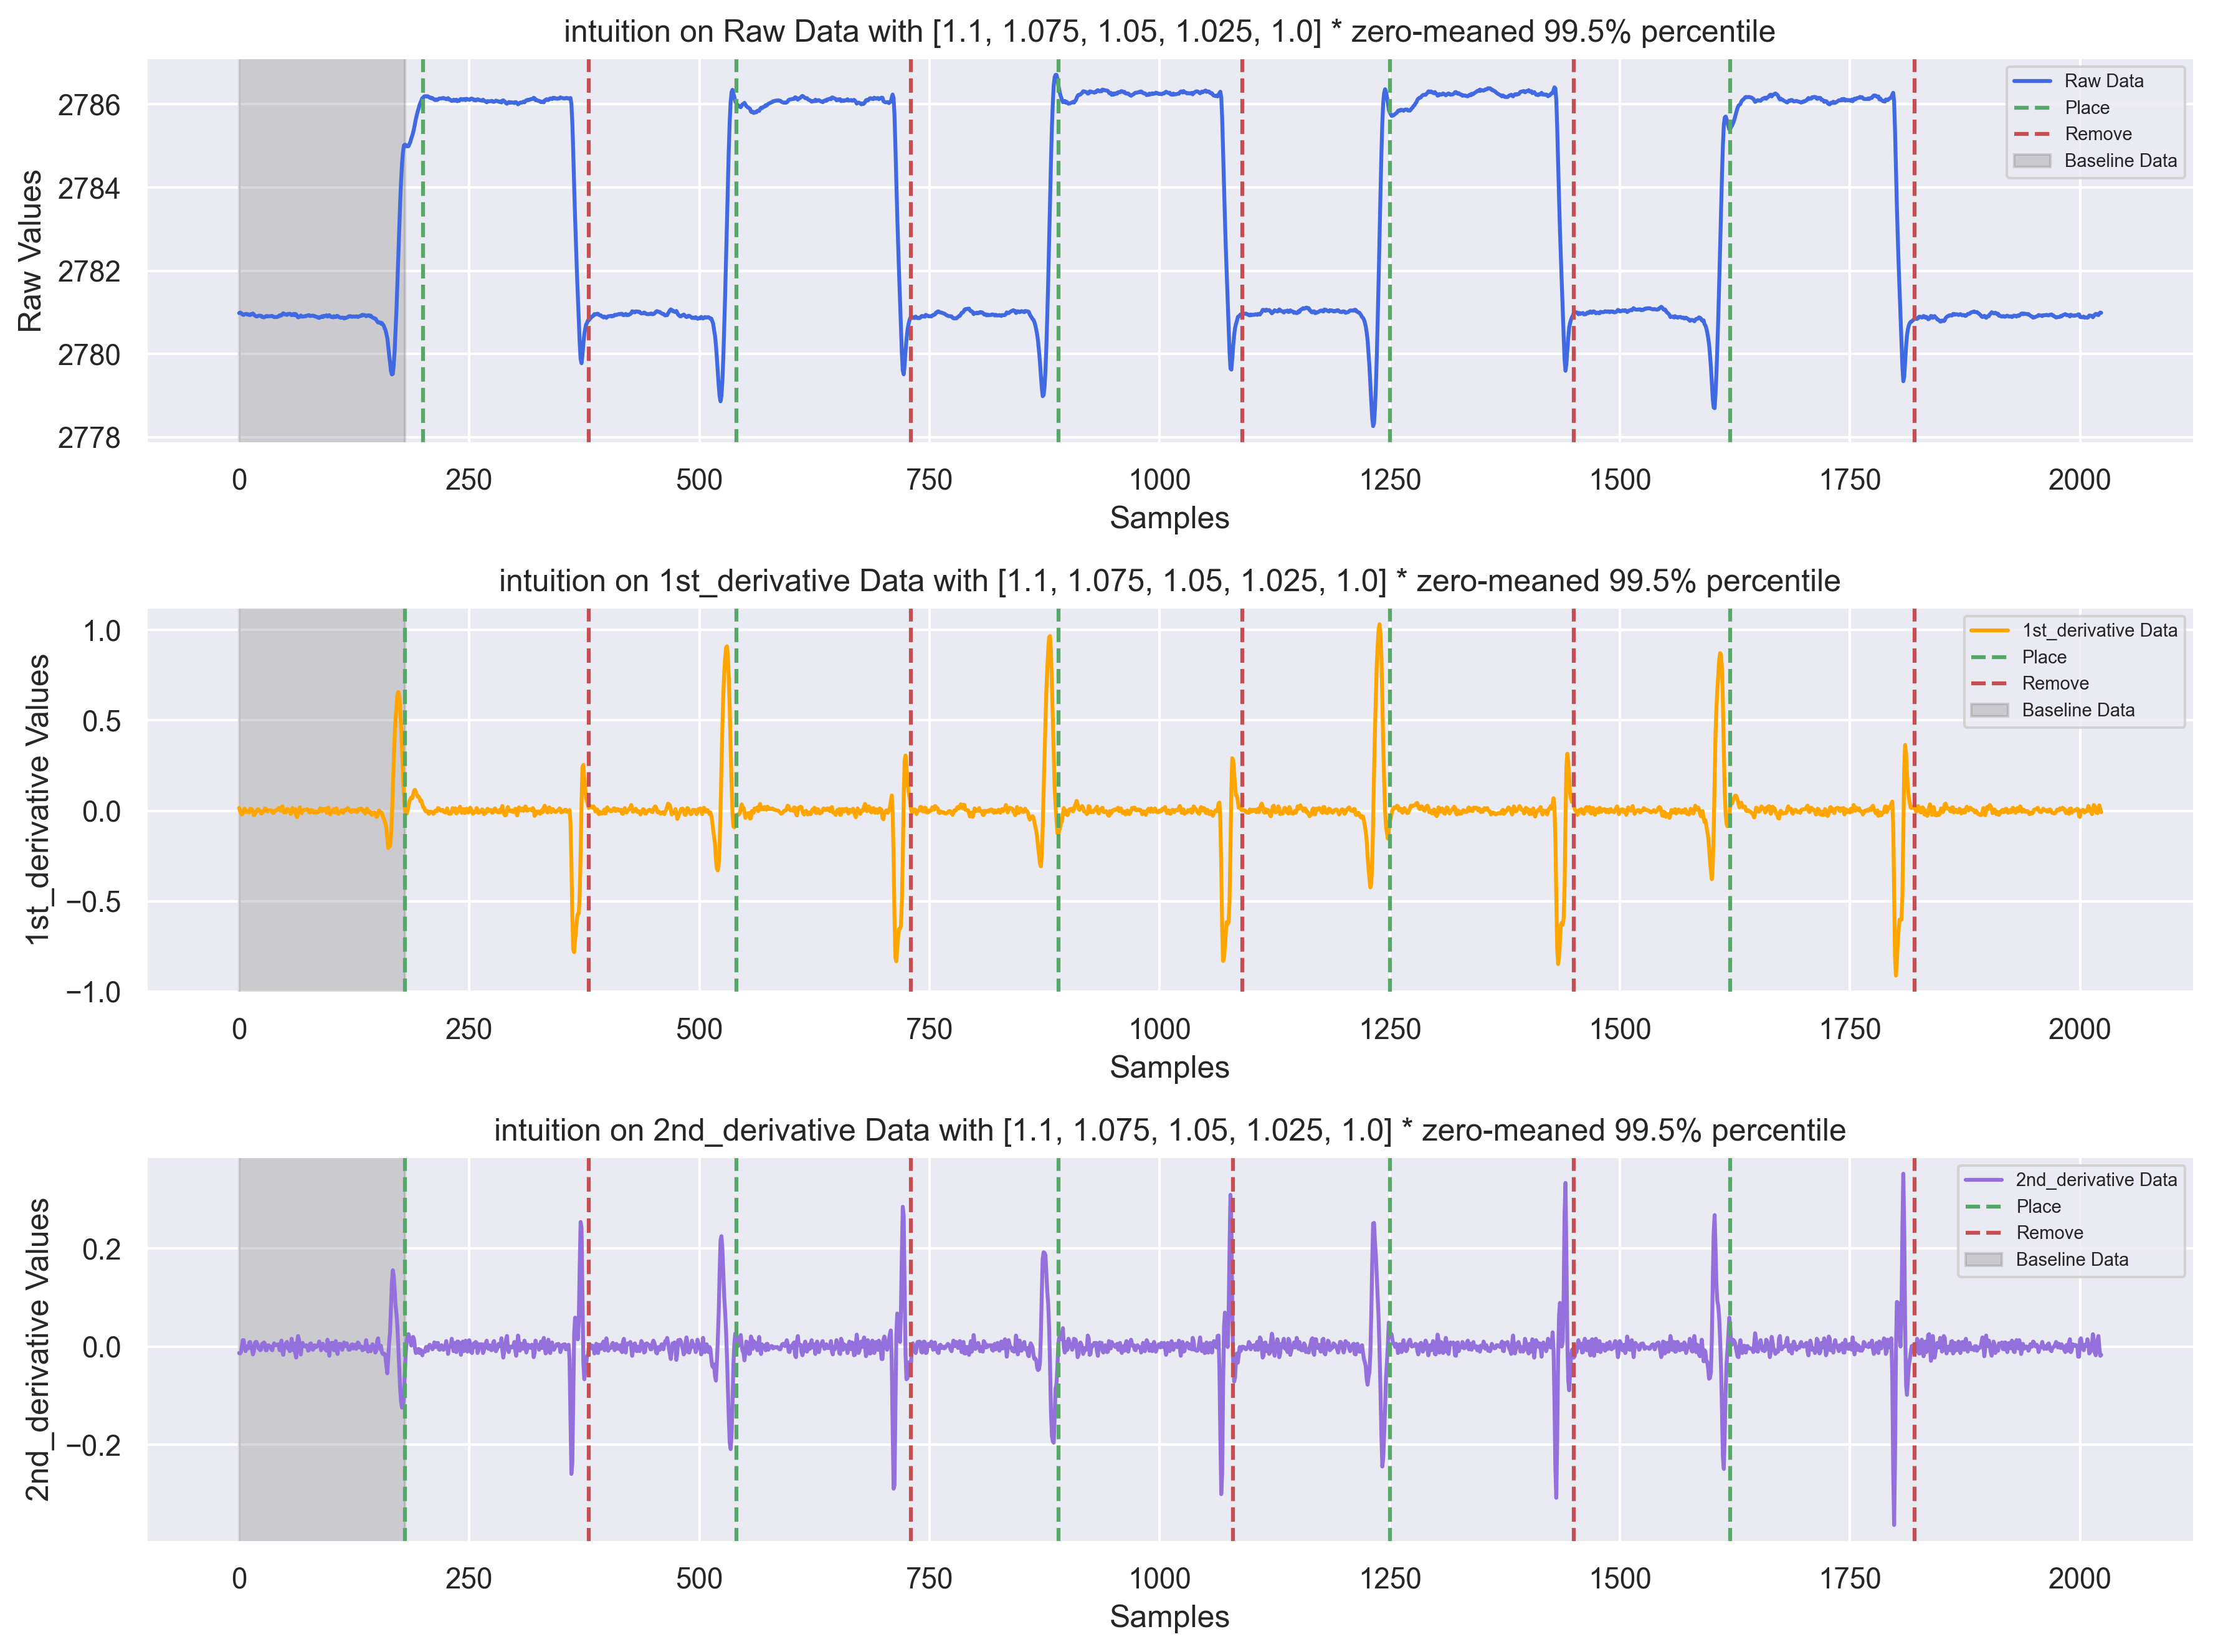

thresholds arrays are as follows: [[0.17732393 0.17329384 0.16926375 0.16523366 0.16120357]
 [0.05148744 0.05031727 0.0491471  0.04797693 0.04680676]
 [0.02519242 0.02461986 0.02404731 0.02347475 0.0229022 ]]


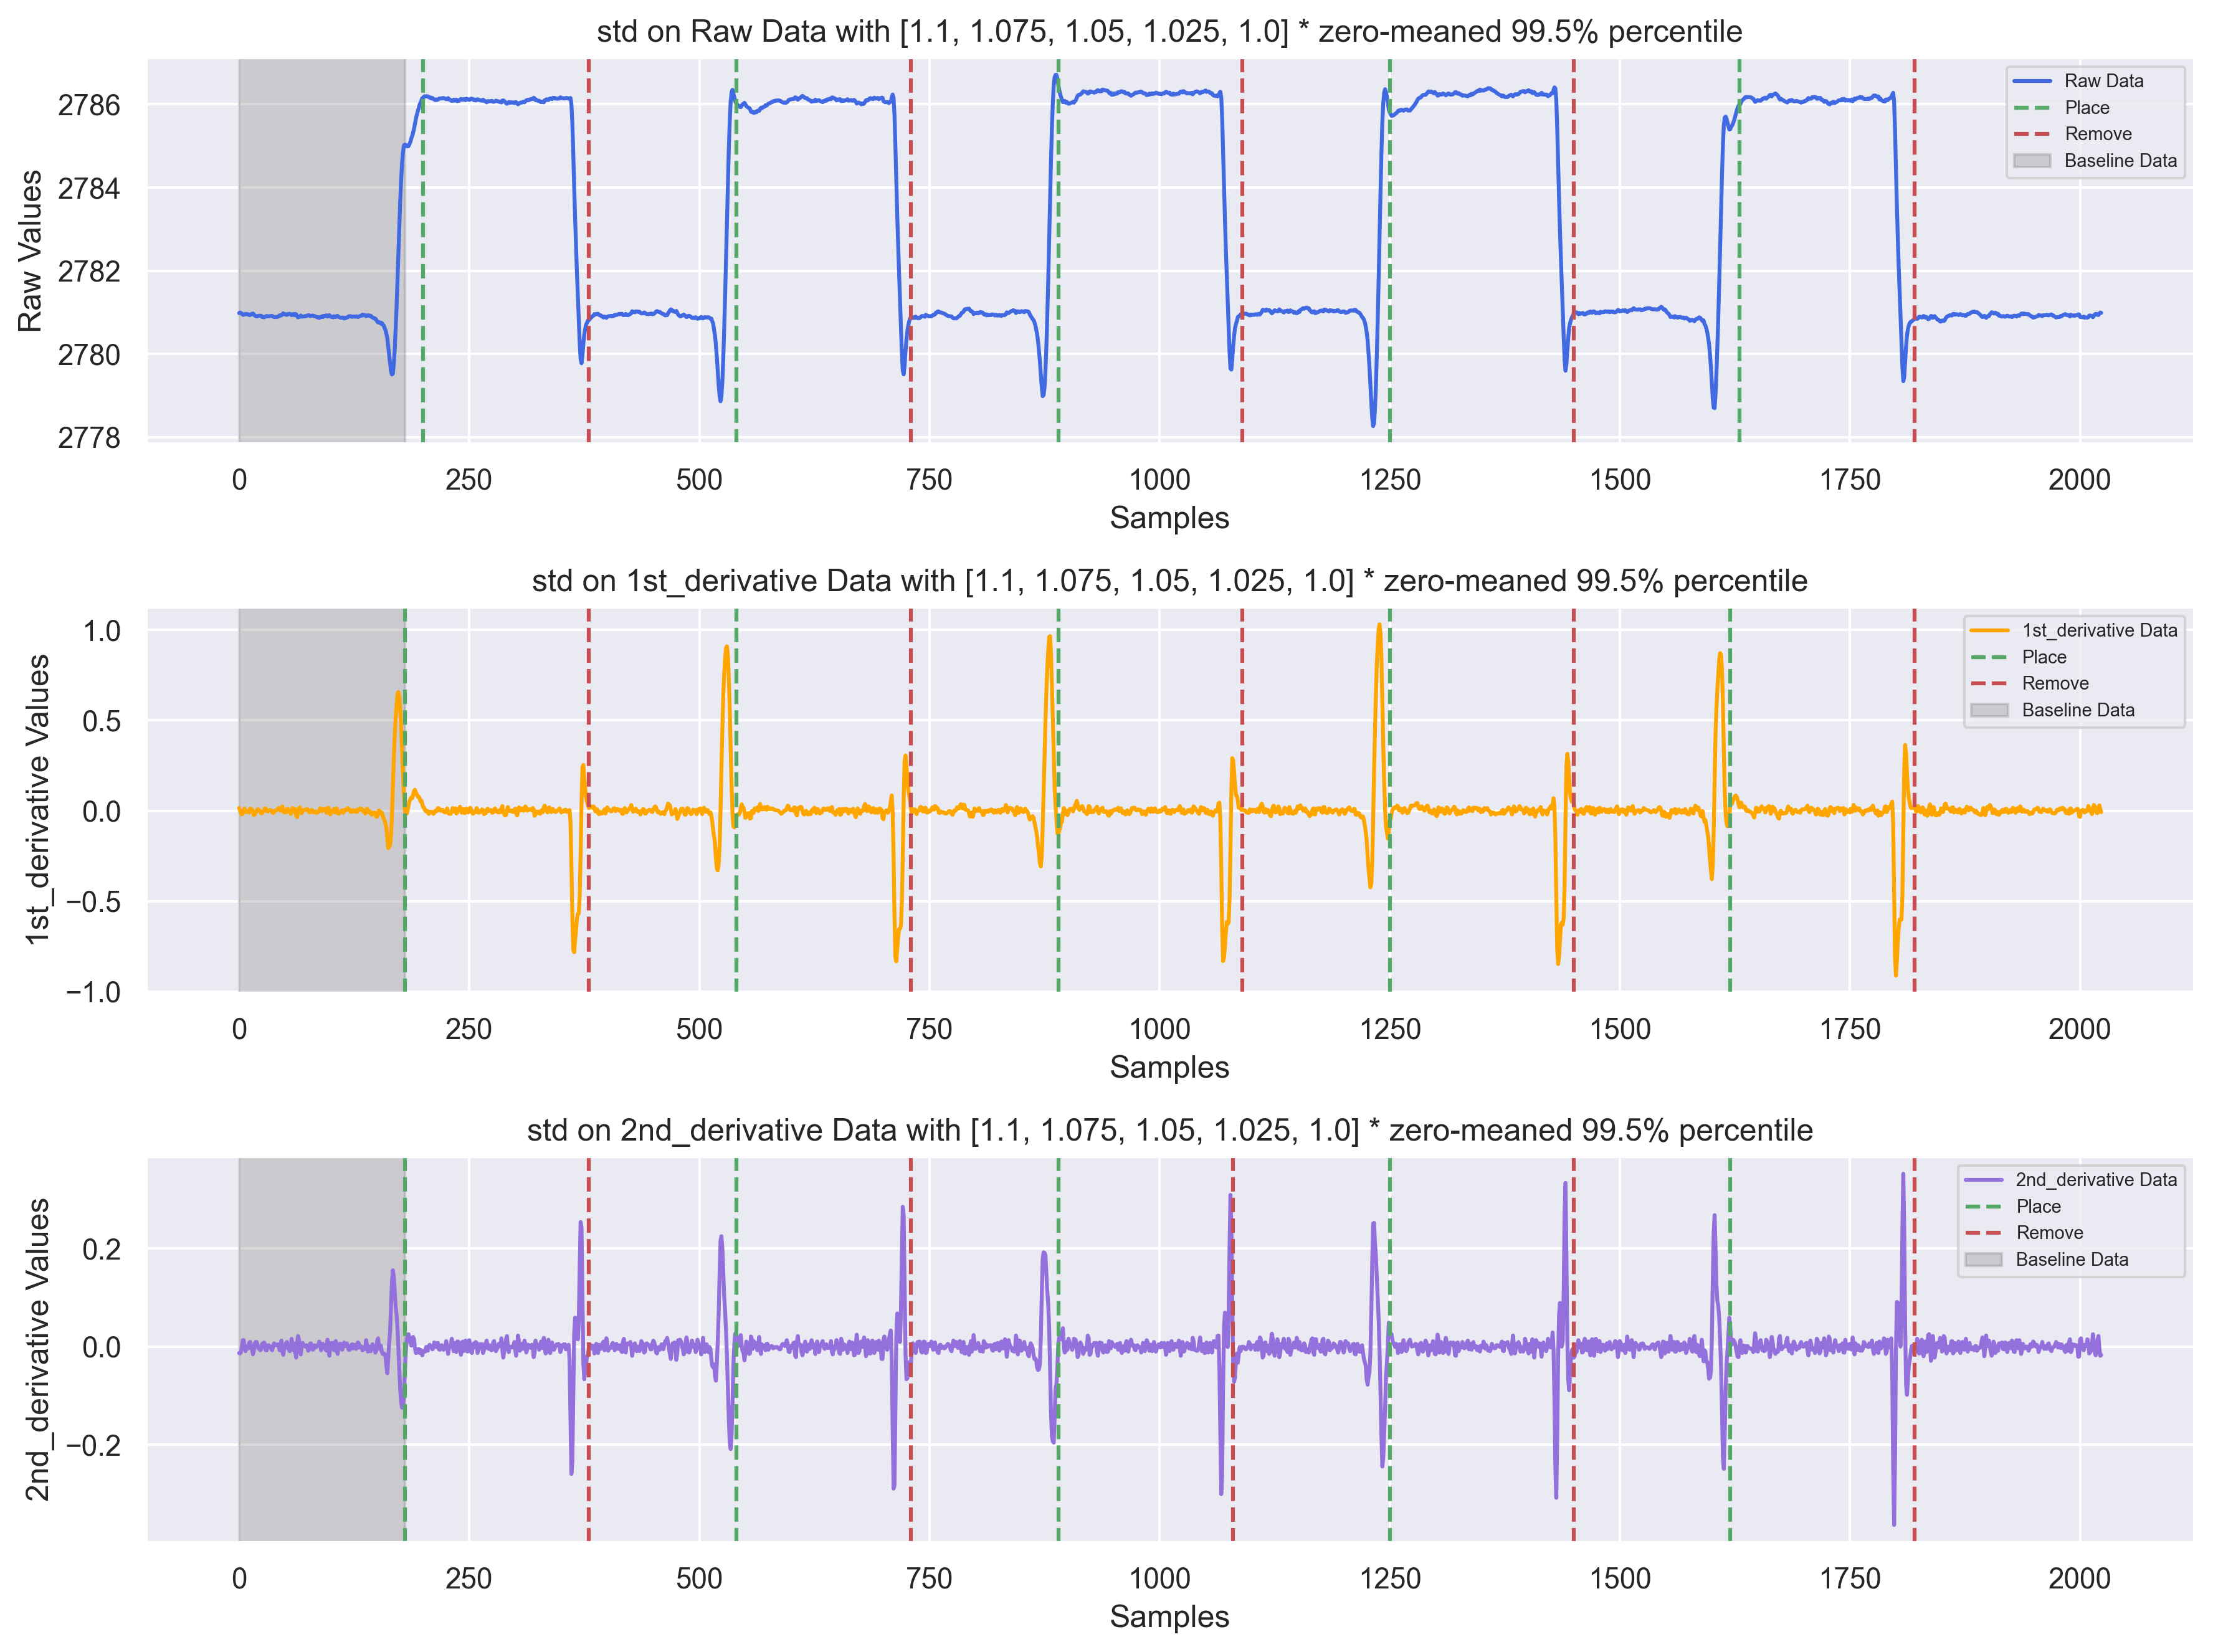

In [561]:

test_df = pd.read_csv("./../data/apr-4-prlm-localisation-data-each-position/apr-4-prlm-place-x=57-5-y=00__5-times.txt", names=["anchor_0", "anchor_1", "anchor_2", "anchor_3", "anchor_4"])




x = place_remove_detect(test_df["anchor_3"], method="intuition", threshold_multipliers=[1.1, 1.075, 1.05, 1.025, 1.])


x = place_remove_detect(test_df["anchor_3"], method="std", threshold_multipliers=[1.1, 1.075, 1.05, 1.025, 1.])


In [ ]:
0, 0, -10, 0, -10, 0, -10, 0, 0, 0

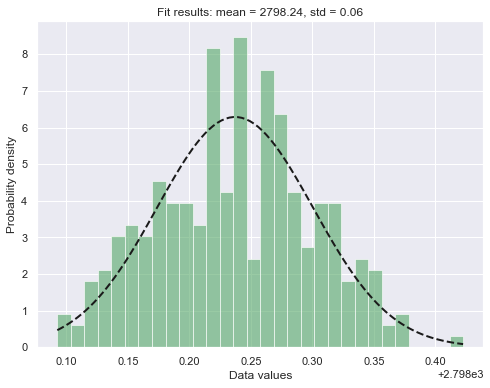

In [181]:
import scipy.stats as stats

# Generate some example sensor data (replace this with your actual data chunk)
data = raw_df_prlm_x_12_5_y_30["anchor_0"][:300]  # mean=10, std=2, 1000 data points

# Calculate the mean and standard deviation of the data
data_mean = np.mean(data)
data_std = np.std(data)

# Fit the data to a normal distribution
pdf_x = np.linspace(np.min(data), np.max(data), 100)
pdf_y = stats.norm.pdf(pdf_x, data_mean, data_std)

# Plotting
plt.figure(figsize=(8, 6))
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')
plt.plot(pdf_x, pdf_y, 'k--', linewidth=2)
plt.title('Fit results: mean = %.2f, std = %.2f' % (data_mean, data_std))
plt.xlabel('Data values')
plt.ylabel('Probability density')
plt.show()